In [27]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

---



*  Creating image generators for each of the three image data sets (train, validation, test). In this step I implement `ImageDataGenerator` to read / decode the images and convert them into floating point tensors.
*   Using the `rescale` argument to rescale the tensors from values between 0 and 255 to values between 0 and 1.

In [29]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory('/content/cats_and_dogs/train', batch_size = 32, target_size = (IMG_HEIGHT,IMG_WIDTH), class_mode = 'binary')
val_data_gen = train_image_generator.flow_from_directory('/content/cats_and_dogs/validation', batch_size = 32, target_size = (IMG_HEIGHT,IMG_WIDTH), class_mode = 'binary')
test_data_gen = train_image_generator.flow_from_directory('/content/cats_and_dogs/',classes=['test'] , batch_size = 32, target_size = (IMG_HEIGHT,IMG_WIDTH), class_mode = 'binary', shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.




---

*   Plotting the images using  `plotImages` function. 
It takes an array of images and a probabilities list.

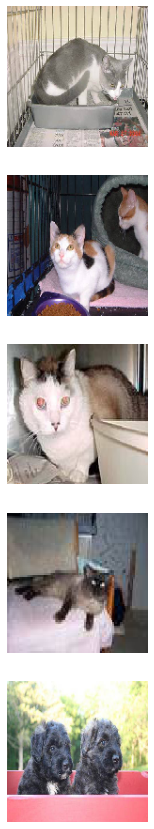

In [30]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])





---



*  Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.
*   Adding 6 random transformations as arguments toÂ `ImageDataGenerator`.

* Recreating the `train_image_generator` using `ImageDataGenerator`.



 






In [31]:
train_image_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 180, horizontal_flip= True, vertical_flip= True, height_shift_range=2, zoom_range=0.5,shear_range=2)


---

*   Using PlotImages function, below are show 5 images from the new `train_image_generator`.


*  A single image is plotted five different times using different variations.


Found 2000 images belonging to 2 classes.


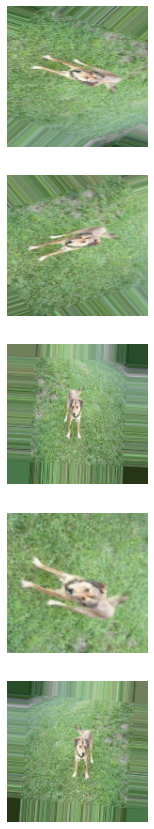

In [32]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)



---



*  A neural network model is defined (using keras). Is conformed by a stack of Conv2D, MaxPooling2D, Flatten, Dense and Dropout layers.
* In this case a relu and sigmoif activation functions are implemented.





In [33]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), activation = 'relu')) #convulucion
model.add(MaxPooling2D(pool_size = (2, 2))) # Pooling
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())
model.add(tf.keras.layers.Dense(units=512, activation= 'relu')) 
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics = ['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 512)              



---



*   Training the network

In [34]:
history = model.fit(train_data_gen, steps_per_epoch=16, epochs=epochs, validation_steps=8, validation_data= val_data_gen)

Epoch 1/20
16/16 [==============================] - 16s 972ms/step - loss: 1.7995 - accuracy: 0.5045 - val_loss: 0.6957 - val_accuracy: 0.4688
Epoch 2/20
16/16 [==============================] - 15s 921ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6928 - val_accuracy: 0.5820
Epoch 3/20
16/16 [==============================] - 16s 1s/step - loss: 0.6854 - accuracy: 0.5580 - val_loss: 0.6828 - val_accuracy: 0.5703
Epoch 4/20
16/16 [==============================] - 15s 927ms/step - loss: 0.6819 - accuracy: 0.5715 - val_loss: 0.6871 - val_accuracy: 0.5586
Epoch 5/20
16/16 [==============================] - 15s 935ms/step - loss: 0.6887 - accuracy: 0.5765 - val_loss: 0.6935 - val_accuracy: 0.5273
Epoch 6/20
16/16 [==============================] - 16s 970ms/step - loss: 0.6881 - accuracy: 0.5260 - val_loss: 0.6945 - val_accuracy: 0.5508
Epoch 7/20
16/16 [==============================] - 15s 922ms/step - loss: 0.6846 - accuracy: 0.5675 - val_loss: 0.7033 - val_accuracy: 0.5859
Ep



---

* The code below helps to visualize the accuracy and loss of the model.


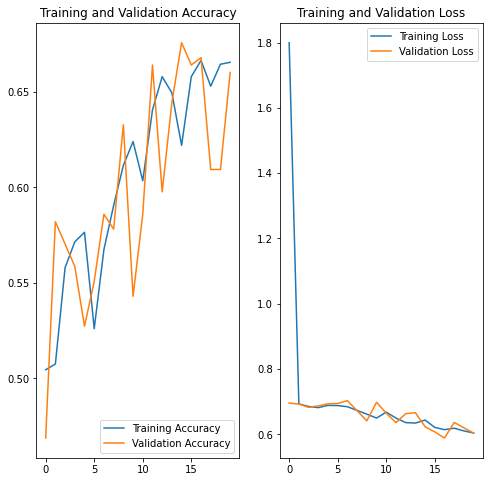

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



---
* Making preddictions


In [36]:
probabilities = model.predict(test_data_gen).flatten()

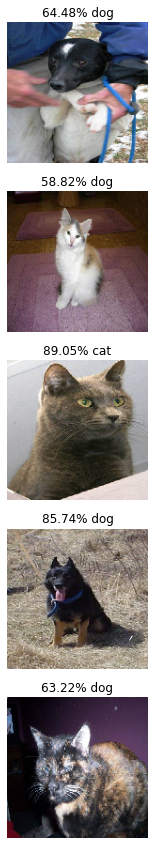

In [37]:
sample_test_images, _ = next(test_data_gen)
plotImages(sample_test_images[:5], probabilities)